# Bayesian linear regression

* [1. What is Bayesian linear regression?](#intro-blr)
* [2. Recap linear regression](#recap-lr)
* [3. Fundamental concepts](#fundamental-concepts)
* [4. Linear regression from a probabilistic perspective](#prob-lr)
* [5. Linear regression with basis functions](#lr-with-basis-functions)
    * [5.1 Example basis functions](#example-basis-function)
    * [5.2 The design matrix](#design-matrix)
* [6. Bayesian Linear Regression](#blr)
    * [6.1 Step 1: Probabilistic Model](#prob-model)
    * [6.2 Generating a dataset](#dataset)
    * [6.3 Step 2: Posterior over the parameters](#param-posterior)
    * [6.4 Visualizing the parameter posterior](#param-posterior-visualization)
    * [6.5 Step 3: Posterior predictive distribution](#predictive-posterior)
    * [6.6 Visualizing the predictive posterior](#predictive-posterior-visualization)

    
* [Sources and further reading](#sources)

## Link to interactive demo

[Click here](https://mybinder.org/v2/gh/zotroneneis/machine_learning_basics/HEAD?filepath=bayesian_linear_regression.ipynb) to run the notebook online (using Binder) without installing jupyter or downloading the code.


Sometimes, the GitHub version of the Jupyter notebook does not display the math formulas correctly. Please refer to the Binder version in case you think something might be off or missing.

I also wrote a [blog post containing the contents of the notebook](https://alpopkes.com/posts/machine_learning/bayesian_linear_regression).

## 1. What is Bayesian linear regression (BLR)?  <a class="anchor" id="intro-blr"></a>
Bayesian linear regression is the *Bayesian* interpretation of linear regression. What does that mean? To answer this question we first have to understand the Bayesian approach. In most of the algorithms we have looked at so far we computed *point estimates* of our parameters. For example, in linear regression we chose values for the weights and bias that minimized our mean squared error cost function. In the Bayesian approach we don't work with exact values but with *probabilities*. This allows us to model the *uncertainty* in our parameter estimates. Why is this important?

In nearly all real-world situations, our data and knowledge about the world is incomplete, indirect and noisy. Hence, uncertainty must be a fundamental part of our decision-making process. This is exactly what the Bayesian approach is about. It provides a formal and consistent way to reason in the presence of uncertainty. Bayesian methods have been around for a long time and are widely-used in many areas of science (e.g. astronomy). Although Bayesian methods have been applied to machine learning problems too, they are usually less well known to beginners. The major reason is that they require a good understanding of probability theory.

In the following notebook we will work our way from linear regression to Bayesian linear regression, including the most important theoretical knowledge and code examples.

## 2. Recap linear regression  <a class="anchor" id="recap-lr"></a>

- In linear regression, we want to find a function $f$ that maps inputs $x \in \mathbb{R}^D$ to corresponding function values $f(x) \in \mathbb{R}$. 
- We are given an input dataset $D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N$, where $y_n$ is a noisy observation value: $y_n = f(x_n) + \epsilon$, with $\epsilon$ being an i.i.d. random variable that describes measurement/observation noise
- Our goal is to infer the underlying function $f$ that generated the data such that we can predict function values at new input locations
- In linear regression, we model the underlying function $f$ using a linear combination of the input features:

$$
\begin{split}
y &= \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_d x_d \\
&= \boldsymbol{x}^T \boldsymbol{\theta}
\end{split}
$$
    
    
- For more details take a look at the [notebook on linear regression](https://github.com/zotroneneis/machine_learning_basics/blob/master/linear_regression.ipynb)

## 3. Fundamental concepts  <a class="anchor" id="fundamental-concepts"></a>
- One fundamental tool in Bayesian learning is [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)
- Bayes' theorem looks as follows:
$$
\begin{equation}
p(\boldsymbol{\theta} | \mathbf{x}, y) = \frac{p(y | \boldsymbol{x}, \boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\boldsymbol{x}, y)}
\end{equation}
$$
- $p(y | \boldsymbol{x}, \boldsymbol{\theta})$ is the *likelihood*. It describes the probability of the target values given the data and parameters.
- $p(\boldsymbol{\theta})$ is the *prior*. It describes our initial knowledge about which parameter values are likely and unlikely.
- $p(\boldsymbol{x}, y)$ is the *evidence*. It describes the joint probability of the data and targets.  
- $p(\boldsymbol{\theta} | \boldsymbol{x}, y)$ is the *posterior*. It describes the probability of the parameters given the observed data and targets.
<br>
- Another important tool you need to know about is the [Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution). If you are not familiar with it I suggest you pause for a minute and understand its main properties before reading on.

In general, Bayesian inference works as follows:
1. We start with some prior belief about a hypothesis $p(h)$
2. We observe some data, representating new evidence $e$
3. We use Bayes' theorem to update our belief given the new evidence: $p(h|e) = \frac{p(e |h)p(h)}{p(e)}$ 

For more information take a look at the [Wikipedia article on Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference).

## 4. Linear regression from a probabilistic perspective  <a class="anchor" id="prob-lr"></a>

In order to pave the way for Bayesian linear regression we will take a probabilistic spin on linear regression. Let's start by explicitly modelling the observation noise $\epsilon$. For simplicity, we assume that $\epsilon$ is normally distributed with mean $0$ and some known variance $\sigma^2$: $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

As mentioned in the beginning, a simple linear regression model assumes that the target function $f(x)$ is given by a linear combination of the input features:
$$
\begin{split}
y = f(\boldsymbol{x}) + \epsilon \\
  = \boldsymbol{x}^T \boldsymbol{\theta} + \epsilon
\end{split}
$$

This corresponds to the following likelihood function: 
$$p(y | \boldsymbol{x}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{x}^T \boldsymbol{\theta}, \sigma^2)$$

Our goal is to find the parameters $\boldsymbol{\theta} = \{\theta_1, ..., \theta_D\}$ that model the given data best.
In standard linear regression we can find the best parameters using a least-squares, maximum likelihood (ML) or maximum a posteriori (MAP) approach. If you want to know more about these solutions take a look at the [notebook on linear regression](https://github.com/zotroneneis/machine_learning_basics/blob/master/linear_regression.ipynb) or at chapter 9.2 of the book [Mathematics for Machine Learning](https://mml-book.com).

## 5. Linear regression with basis functions  <a class="anchor" id="lr-with-basis-functions"></a>
The simple linear regression model above is linear not only with respect to the parameters $\boldsymbol{\theta}$ but also with respect to the inputs $\boldsymbol{x}$. When $\boldsymbol{x}$ is not a vector but a single value (that is, the dataset is one-dimensional) the model $y_i = x_i \cdot \theta$ describes straight lines with $\theta$ being the slope of the line.

The plot below shows example lines produced with the model $y = x \cdot \theta$, using different values for the slope $\theta$ and intercept 0.   

<img src="figures/example_straight_lines.png" alt="Drawing" style="width: 500px;"/>

Having a model which is linear both with respect to the parameters and inputs limits the functions it can learn significantly. We can make our model more powerful by making it *nonlinear* with respect to the inputs. After all, *linear regression* refers to models which are linear in the *parameters*, not necessarily in the *inputs* (linear in the parameters means that the model describes a function by a linear combination of input features).

Making the model nonlinear with respect to the inputs is easy. We can adapt it by using a nonlinear transformation of the input features $\phi(\boldsymbol{x})$. With this adaptation our model looks as follows: 
$$
\begin{split}
y &= \boldsymbol{\phi}^T(\boldsymbol{x}) \boldsymbol{\theta} + \epsilon \\
&= \sum_{k=0}^{K-1} \theta_k \phi_k(\boldsymbol{x}) + \epsilon
\end{split}
$$

Where $\boldsymbol{\phi}: \mathbf{R}^D \rightarrow \mathbf{R}^K$ is a (non)linear transformation of the inputs $\boldsymbol{x}$ and $\phi_k: \mathbf{R}^D \rightarrow \mathbf{R}$ is the $k-$th component of the *feature vector* $\boldsymbol{\phi}$:

$$
\boldsymbol{\phi}(\boldsymbol{x})=\left[\begin{array}{c}
\phi_{0}(\boldsymbol{x}) \\
\phi_{1}(\boldsymbol{x}) \\
\vdots \\
\phi_{K-1}(\boldsymbol{x})
\end{array}
\right]
\in \mathbb{R}^{K}
$$


With our new nonlinear transformation the likelihood function is given by

$$
p(y | \boldsymbol{x}, \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\phi}^T(\boldsymbol{x}) \boldsymbol{\theta},\, \sigma^2)
$$

### 5.1 Example basis functions   <a class="anchor" id="example-basis-function"></a>

#### Linear regression
The easiest example for a basis function (for one-dimensional data) would be simple linear regression, that is, no non-linear transformation at all. In this case we would choose $\phi_0(x) = 1$ and $\phi_i(x) = x$. This would result in the following vector $\boldsymbol{\phi}(x)$:

$$
\boldsymbol{\phi}(x)=
\left[
\begin{array}{c}
\phi_{0}(x) \\
\phi_{1}(x) \\
\vdots \\
\phi_{K-1}(x)
\end{array}
\right] = 
\left[
\begin{array}{c}
1 \\
x \\
\vdots \\
x
\end{array}
\right]
\in \mathbb{R}^{K}
$$

#### Polynomial regression
Another common choice of basis function for the one-dimensional case is polynomial regression. For this we would set $\phi_i(x) = x^i$ for $i=0, ..., K-1$. The corresponding feature vector $\boldsymbol{\phi}(x)$ would look as follows:

$$
\boldsymbol{\phi}(x)=
\left[
\begin{array}{c}
\phi_{0}(x) \\
\phi_{1}(x) \\
\vdots \\
\phi_{K-1}(x)
\end{array}
\right] = 
\left[
\begin{array}{c}
1 \\
x \\
x^2 \\
x^3 \\
\vdots \\
x^{K-1}
\end{array}
\right]
\in \mathbb{R}^{K}
$$

With this transformation we can lift our original one-dimensional input into a $K$-dimensional feature space. Our function $f$ can be any polynomial with degree $\le K-1$: $f(x) = \sum_{k=0}^{K-1} \theta_k x^k$

### 5.2 The design matrix  <a class="anchor" id="design-matrix"></a>
To make it easier to work with the transformations $\boldsymbol{\phi}(\boldsymbol{x})$ for the different input vectors $\boldsymbol{x}$ we typically create a so called *design matrix* (also called *feature matrix*). Given our dataset $D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N$ we define the design matrix as follows:

$$
\boldsymbol{\Phi}:=\left[\begin{array}{c}
\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{1}\right) \\
\vdots \\
\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{N}\right)
\end{array}\right]=\left[\begin{array}{ccc}
\phi_{0}\left(\boldsymbol{x}_{1}\right) & \cdots & \phi_{K-1}\left(\boldsymbol{x}_{1}\right) \\
\phi_{0}\left(\boldsymbol{x}_{2}\right) & \cdots & \phi_{K-1}\left(\boldsymbol{x}_{2}\right) \\
\vdots & & \vdots \\
\phi_{0}\left(\boldsymbol{x}_{N}\right) & \cdots & \phi_{K-1}\left(\boldsymbol{x}_{N}\right)
\end{array}\right] \in \mathbb{R}^{N \times K}
$$

Note that the design matrix is of shape $N \times K$. $N$ is the number of input examples and $K$ is the output dimension of the non-linear transformation $\boldsymbol{\phi}(\boldsymbol{x})$.

## 6. Bayesian linear regression  <a class="anchor" id="blr"></a>
What changes when we consider a Bayesian interpretation of linear regression? Our data stays the same as before: $D = \big \{ \mathbf{x}_n, y_n \big \}_{n=1}^N$. Given the data $D$ we can define the set of all inputs as $\mathcal{X} := \{\boldsymbol{x}_1, ..., \boldsymbol{x}_n\}$ and the set of all targets as $\mathcal{Y} := \{y_1, ..., y_n \}$.

In simple linear regression we compute point estimates of our parameters (e.g. using a maximum likelihood approach) and use these estimates to make predictions. Different to this, Bayesian linear regression estimates *distributions* over the parameters and predictions. This allows us to model the uncertainty in our predictions.

To perform Bayesian linear regression we follow three steps:
1. We set up a probabilistic model that describes our assumptions how the data and parameters are generated
2. We perform inference for the parameters $\boldsymbol{\theta}$, that is, we compute the posterior probability distribution over the parameters
3. With this posterior we can perform inference for new, unseen inputs $y_*$. In this step we don't compute point estimates of the outputs. Instead, we compute the parameters of the posterior distribution over the outputs.

### 6.1 Step 1: Probabilistic model  <a class="anchor" id="prob-model"></a>

We start by setting up a probabilistic model that describes our assumptions how the data and parameters are generated. For this, we place a prior $p(\boldsymbol{\theta})$ over our parameters which encodes what parameter values are plausible (before we have seen any data). Example: With a single parameter $\theta$, a Gaussian  prior $p(\theta) = \mathcal{N}(0, 1)$ says that parameter values are normally distributed with mean 0 and standard deviation 1. In other words: the parameter values are most likely to fall into the interval [−2,2] which is two standard deviations around the mean value.

To keep things simple we will assume a Gaussian prior over the parameters: $p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{m}_0, \boldsymbol{S}_0)$. Let's further assume that the likelihood function is Gaussian, too: $p(y \mid \boldsymbol{x}, \boldsymbol{\theta})=\mathcal{N}\left(y \mid \boldsymbol{\phi}^{\top}(\boldsymbol{x}) \boldsymbol{\theta}, \sigma^{2}\right)$.

Note: When considering the set of all targets $\mathcal{Y} := \{y_1, ..., y_n \}$, the likelihood function becomes a multivariate Gaussian distribution: $p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})=\mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{\Phi} \boldsymbol{\theta}, \sigma^{2} \boldsymbol{I}\right)$

The nice thing about choosing a Gaussian distribution for our prior is that the posterior distributions will be Gaussian, too (keyword [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior))! 

We will start our `BayesianLinearRegression` class with the knowledge we have so far - our probabilistic model. As mentioned in the beginning we assume that the variance $\sigma^2$ of the noise $\epsilon$ is known. Furthermore, to allow plotting the data later on we will assume that it's two dimensional (d=2).

In [1]:
from scipy.stats import multivariate_normal
import numpy as np

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
        
# Let's make sure that we can initialize our model
prior_mean = np.array([0, 0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])
noise_var = 0.2
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

### 6.2 Generating a dataset  <a class="anchor" id="dataset"></a>

Before going any further we need a dataset to test our implementation. Remember that we assume that our targets were generated by a function of the form $y = \boldsymbol{\phi}^T(\boldsymbol{x}) \boldsymbol{\theta} + \epsilon$ where $\epsilon$ is normally distributed with mean $0$ and some known variance $\sigma^2$: $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

To keep things simple we will work with one-dimensional data and simple linear regression (that is, no non-linear transformation of the inputs). Consequently, our data generating function will be of the form
$$ y = \theta_0 + \theta_1 \, x + \epsilon $$

Note that we added a parameter $\theta_0$ which corresponds to the intercept of the linear function. Until know we assumed $\theta_0 = 0$. As mentioned earlier, $\theta_1$ represents the slope of the linear function.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_function_labels(slope: float, intercept: float, noise_std_dev: float, data: np.ndarray) -> np.ndarray:
    """
    Compute target values given function parameters and data.
    
    Args:
        slope: slope of the function (theta_1)
        intercept: intercept of the function (theta_0)
        data: input feature values (x)
        noise_std_dev: standard deviation of noise distribution (sigma)
        
    Returns:
        target values, either true or corrupted with noise
    """
    n_samples = len(data)
    if noise_std_dev == 0: # Real function
        return slope * data + intercept
    else: # Noise corrupted
        return slope * data + intercept + np.random.normal(0, noise_std_dev, n_samples)

In [3]:
# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)

# Generate true values and noise corrupted targets
n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5

# Generate dataset
features = np.random.uniform(lower_bound, upper_bound, n_datapoints)
labels = compute_function_labels(slope, intercept, 0., features)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, features)

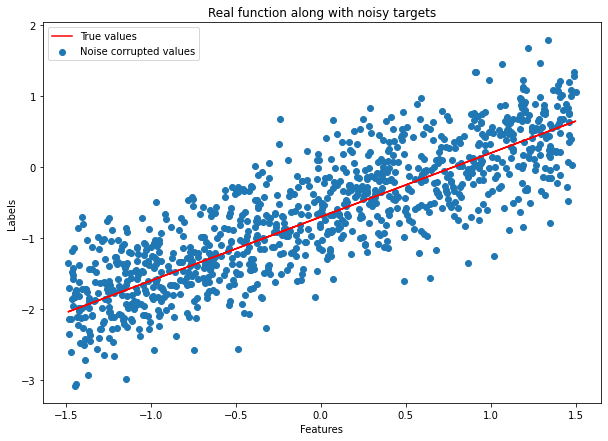

In [4]:
# Plot the dataset
plt.figure(figsize=(10,7))
plt.plot(features, labels, color='r', label="True values")
plt.scatter(features, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

### 6.3 Step 2: Posterior over the parameters  <a class="anchor" id="param-posterior"></a>

We finished setting up our probabilistic model. Next, we want to use this model and our dataset $\mathcal{X, Y}$ to estimate the parameter posterior $p(\boldsymbol{\theta} | \mathcal{X, Y})$. Keep in mind that we don't compute point estimates of the parameters. Instead, we determine the mean and variance of the (Gaussian) posterior distribution and use this entire distribution when making predictions.

We can estimate the parameter posterior using Bayes theorem:
$$
p(\boldsymbol{\theta} \mid \mathcal{X}, \mathcal{Y})=\frac{p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(\mathcal{Y} \mid \mathcal{X})}
$$

- $p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})$ is the likelihood function, $p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})=\mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{\Phi} \boldsymbol{\theta}, \sigma^{2} \boldsymbol{I}\right)$
- $p(\boldsymbol{\theta})$ is the prior distribution, $p(\boldsymbol{\theta})=\mathcal{N}\left(\boldsymbol{\theta} \mid \boldsymbol{m}_{0}, \boldsymbol{S}_{0}\right)$
- $p(\mathcal{Y} \mid \mathcal{X})=\int p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta}) p(\boldsymbol{\theta}) \mathrm{d} \boldsymbol{\theta}$ is the evidence which ensures that the posterior is normalized (that is, that it integrates to 1).

The parameter posterior can be estimated in closed form (for proof see theorem 9.1 in the book [Mathematics for Machine Learning](https://mml-book.com)):
$$
\begin{aligned}
p(\boldsymbol{\theta} \mid \mathcal{X}, \mathcal{Y}) &=\mathcal{N}\left(\boldsymbol{\theta} \mid \boldsymbol{m}_{N}, \boldsymbol{S}_{N}\right) \\
\boldsymbol{S}_{N} &=\left(\boldsymbol{S}_{0}^{-1}+\sigma^{-2} \boldsymbol{\Phi}^{\top} \boldsymbol{\Phi}\right)^{-1} \\
\boldsymbol{m}_{N} &=\boldsymbol{S}_{N}\left(\boldsymbol{S}_{0}^{-1} \boldsymbol{m}_{0}+\sigma^{-2} \boldsymbol{\Phi}^{\top} \boldsymbol{y}\right)
\end{aligned}
$$

Coming back to our `BayesLinearRegression` class we need to add a method which allows us to update the posterior distribution given a dataset.

In [5]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        """
        Update the posterior distribution given new features and targets
        
        Args:
            features: numpy array of features
            targets: numpy array of targets
        """
        # Reshape targets to allow correct matrix multiplication
        # Input shape is (N,) but we need (N, 1)
        targets = targets[:, np.newaxis]
        
        # Compute the design matrix, shape (N, 2)
        design_matrix = self.compute_design_matrix(features)

        # Update the covariance matrix, shape (2, 2)
        design_matrix_dot_product = design_matrix.T.dot(design_matrix)
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.post_cov = np.linalg.inv(inv_prior_cov +  self.noise_precision * design_matrix_dot_product)
        
        # Update the mean, shape (2, 1)
        self.post_mean = self.post_cov.dot( 
                         inv_prior_cov.dot(self.prior_mean) + 
                         self.noise_precision * design_matrix.T.dot(targets))

        
        # Update the posterior distribution
        self.param_posterior = multivariate_normal(self.post_mean.flatten(), self.post_cov)
                
    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        Compute the design matrix. To keep things simple we use simple linear
        regression and add the value phi_0 = 1 to our input data.
        
        Args:
            features: numpy array of features
        Returns:
            design_matrix: numpy array of transformed features
            
        >>> compute_design_matrix(np.array([2, 3]))
        np.array([[1., 2.], [1., 3.])
        """
        n_samples = len(features)
        phi_0 = np.ones(n_samples)
        design_matrix = np.stack((phi_0, features), axis=1)
        return design_matrix
    
 
    def predict(self, features: np.ndarray):
        """
        Compute predictive posterior given new datapoint
        
        Args:
            features: 1d numpy array of features
        Returns:
            pred_posterior: predictive posterior distribution
        """
        design_matrix = self.compute_design_matrix(features)
        
        pred_mean = design_matrix.dot(self.post_mean)
        pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var
        
        pred_posterior = univariate_normal(loc=pred_mean.flatten(), scale=pred_cov**0.5)
        return pred_posterior

### 6.4 Visualizing the parameter posterior  <a class="anchor" id="param-posterior-visualization"></a>

To ensure that our implementation is correct we can visualize how the posterior over the parameters changes as the model sees more data. We will visualize the distribution using a [contour plot](https://en.wikipedia.org/wiki/Contour_line) - a method for visualizing three-dimensional functions. In our case we want to visualize the density of our bi-variate Gaussian for each point (that is, each slope/intercept combination). The plot below shows an example which illustrates how the lines  and colours of a contour plot correspond to a Gaussian distribution:

<img src="figures/density_plot.png" width="400">

As we can see, the density is highest in the yellow regions decreasing when moving further out into the green and blue parts. This should give you a better understanding of contour plots.

To analyze our Bayesian linear regression class we will start by initializing a new model. We can visualize its prior distribution over the parameters *before* the model has seen any real data.

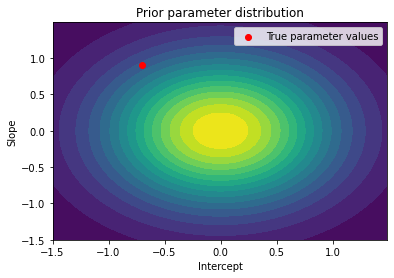

In [6]:
# Initialize BLR model
prior_mean = np.array([0, 0])
prior_cov = 1/2 * np.identity(2)
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

def plot_param_posterior(lower_bound, upper_bound, blr, title):
    fig = plt.figure()
    mesh_features, mesh_labels = np.mgrid[lower_bound:upper_bound:.01, lower_bound:upper_bound:.01]
    pos = np.dstack((mesh_features, mesh_labels))
    plt.contourf(mesh_features, mesh_labels, blr.param_posterior.pdf(pos), levels=15)
    plt.scatter(intercept, slope, color='red', label="True parameter values")
    plt.title(title)
    plt.xlabel("Intercept")
    plt.ylabel("Slope")
    plt.legend();
    
# Visualize parameter prior distribution
plot_param_posterior(lower_bound, upper_bound, blr, title="Prior parameter distribution")

The plot above illustrates both the prior parameter distribution and the true parameter values that we want to find. If our model works correctly, the posterior distribution should become more narrow and move closer to the true parameter values as the model sees more datapoints. This can be visualized with contour plots, too! Below we update the posterior distribution iteratively as the model sees more and more data. The contour plots for each step show how the parameter posterior develops and converges close to the true values in the end.

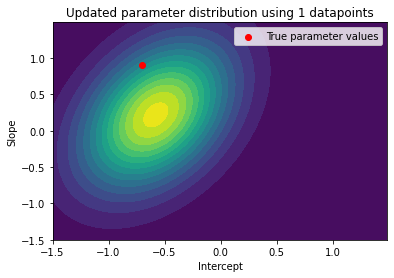

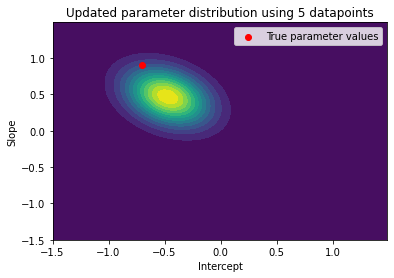

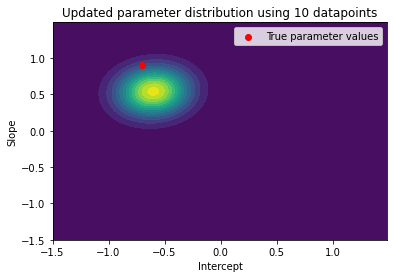

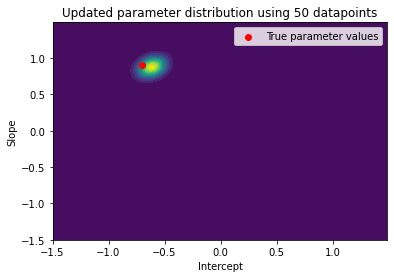

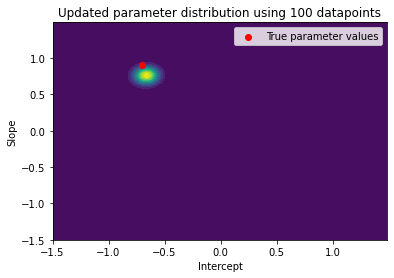

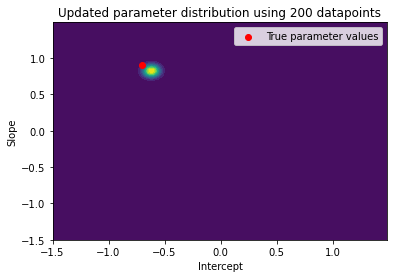

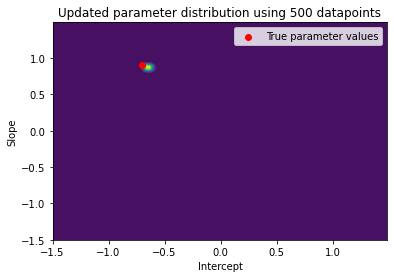

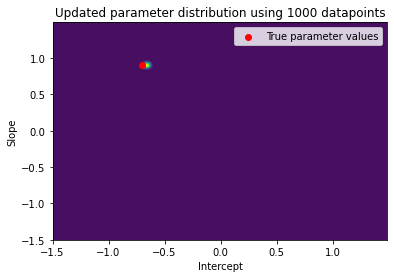

In [7]:
n_points_lst = [1, 5, 10, 50, 100, 200, 500, 1000]
previous_n_points = 0
for n_points in n_points_lst:
    train_features = features[previous_n_points:n_points]
    train_labels = noise_corrupted_labels[previous_n_points:n_points]
    blr.update_posterior(train_features, train_labels)
    
    # Visualize updated parameter posterior distribution
    plot_param_posterior(lower_bound, 
                         upper_bound, 
                         blr, 
                         title=f"Updated parameter distribution using {n_points} datapoints")
    
    previous_n_points = n_points

### 6.5 Step 3: Posterior predictive distribution  <a class="anchor" id="predictive-posterior"></a>
 
Given the posterior distribution over the parameters we can determine the predictive distribution (= posterior over the outputs) for a new input $(\boldsymbol{x}_*, y_*)$. This is the distribution we are really interested in. A trained model is not particularly useful when we can't use it to make predictions, right?

The posterior predictive distribution looks as follows:

$$
\begin{aligned}
p\left(y_{*} \mid \mathcal{X}, \mathcal{Y}, \boldsymbol{x}_{*}\right) &=\int p\left(y_{*} \mid \boldsymbol{x}_{*}, \boldsymbol{\theta}\right) p(\boldsymbol{\theta} \mid \mathcal{X}, \mathcal{Y}) \mathrm{d} \boldsymbol{\theta} \\
&=\int \mathcal{N}\left(y_{*} \mid \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{\theta}, \sigma^{2}\right) \mathcal{N}\left(\boldsymbol{\theta} \mid \boldsymbol{m}_{N}, \boldsymbol{S}_{N}\right) \mathrm{d} \boldsymbol{\theta} \\
&=\mathcal{N}\left(y_{*} \mid \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{m}_{N}, \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{S}_{N} \boldsymbol{\phi}\left(\boldsymbol{x}_{*}\right)+\sigma^{2}\right)
\end{aligned}
$$

First of all: note that the predictive posterior for a new input $\boldsymbol{x}_{*}$ is a *univariate* Gaussian distribution. We can see that the mean of the distribution is given by the product of the design matrix for the new example ($\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right)$) and the mean of the parameter posterior ($\boldsymbol{m}_{N}$). The variance $(\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{S}_{N} \boldsymbol{\phi}\left(\boldsymbol{x}_{*}\right)+\sigma^{2}$) of the predictive posterior has two parts:
1. $\sigma^{2}$: The variance of the noise 
2. $\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{S}_{N} \boldsymbol{\phi}\left(\boldsymbol{x}_{*}\right)$: The posterior uncertainty associated with the parameters $\boldsymbol{\theta}$

Let's add a `predict` method to our `BayesianLinearRegression` class which computes the predictive posterior for a new input (you will find the method in the class definition above):

In [8]:
def predict(self, features: np.ndarray):
    """
    Compute predictive posterior given new datapoint

    Args:
        features: 1d numpy array of features
    Returns:
        pred_posterior: predictive posterior distribution
    """
    design_matrix = self.compute_design_matrix(features)

    pred_mean = design_matrix.dot(self.post_mean)
    pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var

    pred_posterior = univariate_normal(pred_mean.flatten(), pred_cov)
    return pred_posterior

### 6.6 Visualizing the predictive posterior  <a class="anchor" id="predictive-posterior-visualization"></a>

Our original dataset follows a simple linear function. After training the model it should be able to predict labels for new datapoints, even if they lie beyond the range from [-1.5, 1.5]. But how can we get from the predictive distribution that our model computes to actual labels? That's easy: we *sample* from the predictive posterior.

To make sure that we are all on the same page: given a new input example our Bayesian linear regression model predicts not a single label but a *distribution* over possible labels. This distribution is Gaussian. We can get actual labels by sampling from this distribution. 

The code below implements and visualizes this:
- We create some test features for which we want predictions
- Each feature is given to the trained BLR model which returns a univariate Gaussian distribution over possible labels (`pred_posterior = blr.predict(np.array([feat]))`)
- We sample from this distribution (`sample_predicted_labels = pred_posterior.rvs(size=sample_size)`)
- The predicted labels are saved in a format that makes it easy to plot them
- Finally, we plot each input feature, its true label and the sampled predictions. Remember: the samples are generated from the predictive posterior returned by the `predict` method. Think of a Gaussian distribution plotted along the y-axis for each feature. We visualize this with a histogram: more likely values close to the mean will be sampled more often than less likely values.

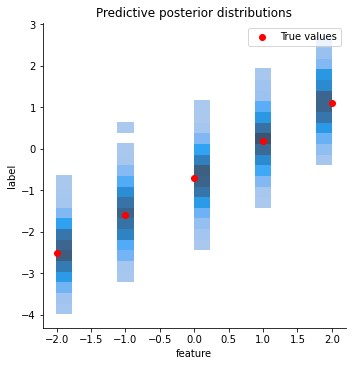

In [9]:
import pandas as pd
import seaborn as sns

all_rows = []
sample_size = 1000
test_features = [-2, -1, 0, 1, 2]
all_labels = []

for feat in test_features:
    true_label = compute_function_labels(slope, intercept, 0, np.array([feat]))
    all_labels.append(true_label)
    pred_posterior = blr.predict(np.array([feat]))
    sample_predicted_labels = pred_posterior.rvs(size=sample_size)
    for label in sample_predicted_labels:
        all_rows.append([feat, label])
        
all_data = pd.DataFrame(all_rows, columns=["feature", "label"]) 
sns.displot(data=all_data, x="feature", y="label")
plt.scatter(x=test_features, y=all_labels, color="red", label="True values")
plt.title("Predictive posterior distributions")
plt.legend()
plt.plot();

## Sources and further reading <a class="anchor" id="sources"></a> 

The basis for this notebook is chapter 9.2 of the book [Mathematics for Machine Learning](https://mml-book.com). I can highly recommend to read through chapter 9 to get a deeper understanding of (Bayesian) linear regression.
   
You will find explanations and an implementation of simple linear regression in the [notebook on linear regression](https://github.com/zotroneneis/machine_learning_basics/blob/master/linear_regression.ipynb)